## <font color=blue> Advanced Regression - Assignment - Australia Real Estate Market
> by Sankalp Gupta

#### <font color=blue> Step 1: </font> Import Libraries

In [1]:
import numpy as np, pandas as pd

In [2]:
import matplotlib.pyplot as plt, seaborn as sns

In [3]:
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.feature_selection import RFE

In [4]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split as tts

In [5]:
import statsmodels.api as sm_api

In [6]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF

In [7]:
import copy

In [8]:
import warnings
warnings.filterwarnings ('ignore')

#### <font color=blue> Step 2: </font> Read CSV Data file

In [9]:
houses = pd.read_csv ('train.csv')

In [10]:
houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [11]:
houses.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [12]:
nulls = houses.loc[:, houses.isna().any()].isna().sum()
nulls = round (nulls*100/houses.shape[0], 2)
nulls.sort_values(ascending=False)

PoolQC          99.52
MiscFeature     96.30
Alley           93.77
Fence           80.75
FireplaceQu     47.26
LotFrontage     17.74
GarageType       5.55
GarageYrBlt      5.55
GarageFinish     5.55
GarageQual       5.55
GarageCond       5.55
BsmtExposure     2.60
BsmtFinType2     2.60
BsmtFinType1     2.53
BsmtCond         2.53
BsmtQual         2.53
MasVnrArea       0.55
MasVnrType       0.55
Electrical       0.07
dtype: float64

#### <font color=blue> Step 3: </font> Clean and Process Data

In [13]:
#Create a list to store all the columns to be removed from regression analysis
single_value_columns = []

#### <font color=blue> Step 3.1: </font> Identify and Study the Target variable 

In [14]:
houses['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<AxesSubplot:>

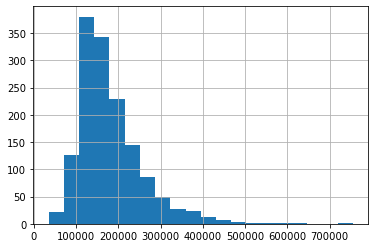

In [15]:
houses['SalePrice'].hist(bins=20)

<AxesSubplot:ylabel='SalePrice'>

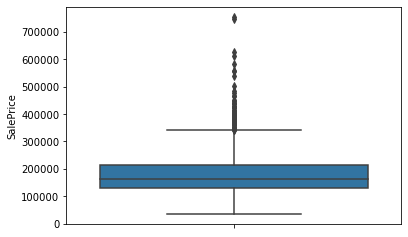

In [16]:
sns.boxplot(y=houses['SalePrice'])

<AxesSubplot:>

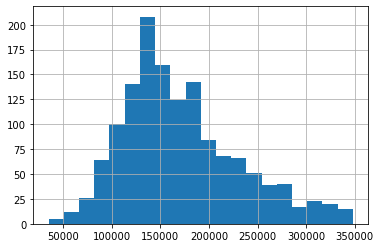

In [17]:
houses['SalePrice'][houses['SalePrice'] < 350000].hist(bins=20)

<AxesSubplot:ylabel='SalePrice'>

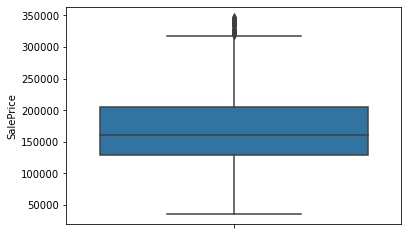

In [18]:
sns.boxplot(y=houses['SalePrice'][houses['SalePrice'] < 350000])

In [19]:
houses['SalePrice'][houses['SalePrice'] >= 350000].count()*100/houses.shape[0]

3.835616438356164

In [20]:
houses['SalePrice'][houses['SalePrice'] < 350000].describe()

count      1404.000000
mean     170857.111111
std       60027.928728
min       34900.000000
25%      129000.000000
50%      159922.500000
75%      204925.000000
max      348000.000000
Name: SalePrice, dtype: float64

In [21]:
#median_SalePrice = houses['SalePrice'][houses['SalePrice'] < 350000].median()
median_SalePrice = houses['SalePrice'].median()

In [22]:
#mean_SalePrice = houses['SalePrice'][houses['SalePrice'] < 350000].mean()
mean_SalePrice = houses['SalePrice'].mean()

#### <font color=blue> Step 3.2: </font> EDA of all the features

In [23]:
#1st Column - Row IDs. Are not required for Regression Analysis
houses.drop (columns=['Id'], axis=1, inplace=True)

In [24]:
#2nd Column - Code for type of dwellings.
houses['MSSubClass'].value_counts()

20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64

In [25]:
#Will not convert them into strings right now, as the strings are too long.
#If any of these turn up as predictor variables, then the codes can be interpreted then
houses['MSSubClass'] = houses ['MSSubClass'].apply (lambda x: '_'.join (['SubClass', str(x)]))

subclasses = pd.get_dummies(houses['MSSubClass'], drop_first=True)
houses = pd.concat ([houses, subclasses], axis=1)

houses.drop (columns=['MSSubClass'], axis=1, inplace=True)

In [26]:
#3rd Column
houses['MSZoning'].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [27]:
houses['MSZoning'] = houses ['MSZoning'].apply (lambda x: '_'.join ([x, 'Zone']))

zones = pd.get_dummies(houses['MSZoning'], drop_first=True)
houses = pd.concat ([houses, zones], axis=1)

houses.drop (columns=['MSZoning'], axis=1, inplace=True)

<AxesSubplot:>

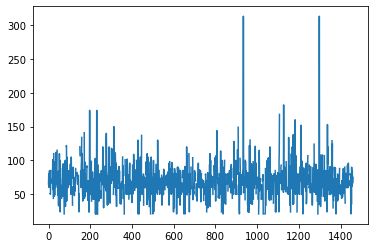

In [28]:
#4th Column
houses['LotFrontage'].plot()

In [29]:
# LotFrontag - About 18% rows contain Nulls. Its best to replace them by the median value, instead of dropping these rows
houses['LotFrontage'].fillna(houses['LotFrontage'].median(), inplace=True)

<AxesSubplot:>

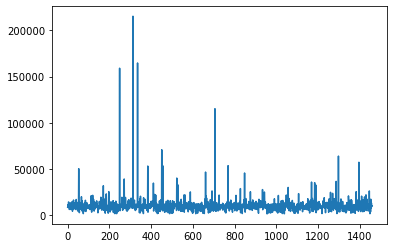

In [30]:
#5th Column
houses['LotArea'].plot()

In [31]:
#6th Column
houses['Street'].value_counts()

Pave    1454
Grvl       6
Name: Street, dtype: int64

In [32]:
100*1454/1460

99.58904109589041

In [33]:
houses['Paved_Street'] = houses ['Street'].map({'Pave':1, 'Grvl':0})

#Removing this column as 99.6% rows contain the same value
single_value_columns.append ('Paved_Street')

houses.drop (columns=['Street'], axis=1, inplace=True)

In [34]:
#7th Column
houses['Alley'].value_counts()

Grvl    50
Pave    41
Name: Alley, dtype: int64

In [35]:
#Contains mostly null values - Nulls are assumed to be No Alley access 

houses['Grvl_Alley'] = houses['Alley'].apply (lambda x: 1 if x == 'Grvl' else 0)
houses['Pave_Alley'] = houses['Alley'].apply (lambda x: 1 if x == 'Pave' else 0)

houses.drop (columns=['Alley'], axis=1, inplace=True)

In [36]:
#8th Column
houses['LotShape'].value_counts()

Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64

In [37]:
houses['LotShape'] = houses ['LotShape'].apply (lambda x: '_'.join (['LotShape', x]))

lots = pd.get_dummies(houses['LotShape'], drop_first=True)
houses = pd.concat ([houses, lots], axis=1)

houses.drop (columns=['LotShape'], axis=1, inplace=True)

In [38]:
#9th Column
houses['LandContour'].value_counts()

Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64

In [39]:
houses['LandContour'] = houses ['LandContour'].apply (lambda x: '_'.join ([x, 'Contour']))

contour = pd.get_dummies(houses['LandContour'], drop_first=True)
houses = pd.concat ([houses, contour], axis=1)

houses.drop (columns=['LandContour'], axis=1, inplace=True)

In [40]:
#10th Column
houses['Utilities'].value_counts()

AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64

In [41]:
#Utilities column is being dropped, as there is only 1 row with Utilities = NoSeWa

houses['AllPub_Utilities'] = houses ['Utilities'].map({'AllPub':1, 'NoSeWa':0})
single_value_columns.append ('AllPub_Utilities')

houses.drop (columns=['Utilities'], axis=1, inplace=True)

In [42]:
houses.shape

(1460, 101)

#### <font color=red> Columns 1 to 10 processed </font>

In [43]:
#11th Column
houses['LotConfig'].value_counts()

Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64

In [44]:
houses['LotConfig'] = houses ['LotConfig'].apply (lambda x: '_'.join ([x, 'Lot']))

lots = pd.get_dummies(houses['LotConfig'], drop_first=True)
houses = pd.concat ([houses, lots], axis=1)

houses.drop (columns=['LotConfig'], axis=1, inplace=True)

In [45]:
#12th Column
houses['LandSlope'].value_counts()

Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64

In [46]:
houses['LandSlope'] = houses ['LandSlope'].apply (lambda x: '_'.join ([x, 'Slope']))

slope = pd.get_dummies(houses['LandSlope'], drop_first=True)
houses = pd.concat ([houses, slope], axis=1)

houses.drop (columns=['LandSlope'], axis=1, inplace=True)

In [47]:
#13th Column
houses['Neighborhood'].value_counts()

NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
StoneBr     25
SWISU       25
MeadowV     17
Blmngtn     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64

In [48]:
houses['Neighborhood'] = houses ['Neighborhood'].apply (lambda x: '_'.join ([x, 'Nbrhood']))

neighbour = pd.get_dummies(houses['Neighborhood'], drop_first=True)
houses = pd.concat ([houses, neighbour], axis=1)

houses.drop (columns=['Neighborhood'], axis=1, inplace=True)

In [49]:
#14th Column
houses['Condition1'].value_counts()

Norm      1260
Feedr       81
Artery      48
RRAn        26
PosN        19
RRAe        11
PosA         8
RRNn         5
RRNe         2
Name: Condition1, dtype: int64

In [50]:
#15th Column
houses['Condition2'].value_counts()

Norm      1445
Feedr        6
Artery       2
RRNn         2
PosN         2
PosA         1
RRAn         1
RRAe         1
Name: Condition2, dtype: int64

In [51]:
houses['Condition2'][houses['Condition1'] == 'Norm'].value_counts()

Norm    1260
Name: Condition2, dtype: int64

In [52]:
houses['Near_Feedr']  = houses.apply (lambda x: 1 if x['Condition1'] == 'Feedr' or x['Condition2'] == 'Feedr' else 0, axis=1)
houses['Near_Artery'] = houses.apply (lambda x: 1 if x['Condition1'] == 'Artery' or x['Condition2'] == 'Artery' else 0, axis=1)
houses['Near_RRAn']   = houses.apply (lambda x: 1 if x['Condition1'] == 'RRAn' or x['Condition2'] == 'RRAn' else 0, axis=1)
houses['Near_PosN']   = houses.apply (lambda x: 1 if x['Condition1'] == 'PosN' or x['Condition2'] == 'PosN' else 0, axis=1)
houses['Near_RRAe']   = houses.apply (lambda x: 1 if x['Condition1'] == 'RRAe' or x['Condition2'] == 'RRAe' else 0, axis=1)
houses['Near_PosA']   = houses.apply (lambda x: 1 if x['Condition1'] == 'PosA' or x['Condition2'] == 'PosA' else 0, axis=1)
houses['Near_RRNn']   = houses.apply (lambda x: 1 if x['Condition1'] == 'RRNn' or x['Condition2'] == 'RRNn' else 0, axis=1)
houses['Near_RRNe']   = houses.apply (lambda x: 1 if x['Condition1'] == 'RRNe' or x['Condition2'] == 'RRNe' else 0, axis=1)

houses.drop (columns=['Condition1', 'Condition2'], axis=1, inplace=True)

In [53]:
#16th Column
houses['BldgType'].value_counts()

1Fam      1220
TwnhsE     114
Duplex      52
Twnhs       43
2fmCon      31
Name: BldgType, dtype: int64

In [54]:
houses['BldgType'] = houses ['BldgType'].apply (lambda x: '_'.join ([x, 'Bldg']))

bldg = pd.get_dummies(houses['BldgType'], drop_first=True)
houses = pd.concat ([houses, bldg], axis=1)

houses.drop (columns=['BldgType'], axis=1, inplace=True)

In [55]:
#17th Column
houses['HouseStyle'].value_counts()

1Story    726
2Story    445
1.5Fin    154
SLvl       65
SFoyer     37
1.5Unf     14
2.5Unf     11
2.5Fin      8
Name: HouseStyle, dtype: int64

In [56]:
houses['HouseStyle'] = houses ['HouseStyle'].apply (lambda x: '_'.join ([x, 'House']))

house = pd.get_dummies(houses['HouseStyle'], drop_first=True)
houses = pd.concat ([houses, house], axis=1)

houses.drop (columns=['HouseStyle'], axis=1, inplace=True)

<AxesSubplot:>

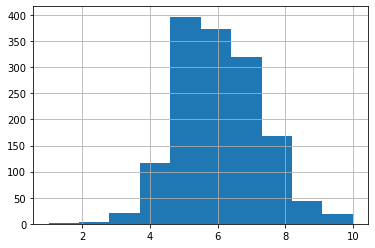

In [57]:
#18th Column
houses['OverallQual'].hist()

<AxesSubplot:>

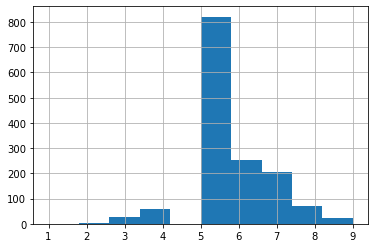

In [58]:
#19th Column
houses['OverallCond'].hist()

<AxesSubplot:>

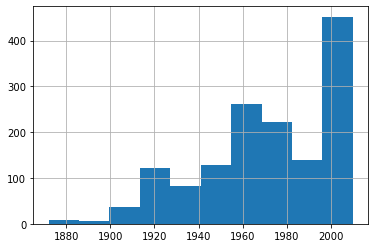

In [59]:
#20th Column
houses['YearBuilt'].hist()

In [60]:
year_built_cut_labels = ['1945_and_older', '20_to_77_years_old', '5_20_years_old', 'recently_built']
year_built_cut_bins = [0, 1945, 2002, 2017, 2022]

houses['EraBuilt'] = pd.cut (houses['YearBuilt'], bins=year_built_cut_bins, labels=year_built_cut_labels)

In [61]:
houses['EraBuilt'].value_counts()

20_to_77_years_old    859
5_20_years_old        321
1945_and_older        280
recently_built          0
Name: EraBuilt, dtype: int64

In [62]:
houses['1945_and_older'] = houses['EraBuilt'].apply (lambda x: 1 if x == '1945_and_older' else 0)
houses['20_to_77_years_old']  = houses['EraBuilt'].apply (lambda x: 1 if x == '20_to_77_years_old' else 0)
houses['5_20_years_old']      = houses['EraBuilt'].apply (lambda x: 1 if x == '5_20_years_old' else 0)

houses.drop (columns=['EraBuilt', 'YearBuilt'], axis=1, inplace=True)

In [63]:
houses.shape

(1460, 145)

#### <font color=red> Columns 11 to 20 processed </font>

<AxesSubplot:>

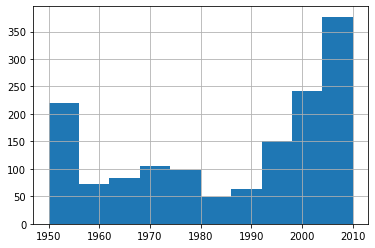

In [64]:
#21st Column
houses['YearRemodAdd'].hist()

In [65]:
year_mod_cut_labels = ['Remodelled_before_1946', 'Remodelled_in_last_77_years', 
                       'Remodelled_in_last_20_years', 'Remodelled_in_last_5_years']

houses['Remodelled'] = pd.cut (houses['YearRemodAdd'], bins=year_built_cut_bins, labels=year_mod_cut_labels)

In [66]:
houses['Remodelled'].value_counts()

Remodelled_in_last_77_years    1032
Remodelled_in_last_20_years     428
Remodelled_before_1946            0
Remodelled_in_last_5_years        0
Name: Remodelled, dtype: int64

In [67]:
houses['Remodelled_in_last_77_years'] = houses['Remodelled'].apply (lambda x: 1 if x == 'Remodelled_in_last_77_years' else 0)
houses['Remodelled_in_last_20_years']  = houses['Remodelled'].apply (lambda x: 1 if x == 'Remodelled_in_last_20_years' else 0)

houses.drop (columns=['Remodelled', 'YearRemodAdd'], axis=1, inplace=True)

In [68]:
#22nd Column
houses['RoofStyle'].value_counts()

Gable      1141
Hip         286
Flat         13
Gambrel      11
Mansard       7
Shed          2
Name: RoofStyle, dtype: int64

In [69]:
houses['RoofStyle'] = houses ['RoofStyle'].apply (lambda x: '_'.join ([x, 'Roof']))

roof = pd.get_dummies(houses['RoofStyle'], drop_first=True)
houses = pd.concat ([houses, roof], axis=1)

houses.drop (columns=['RoofStyle'], axis=1, inplace=True)

In [70]:
#23rd Column
houses['RoofMatl'].value_counts()

CompShg    1434
Tar&Grv      11
WdShngl       6
WdShake       5
Metal         1
Membran       1
Roll          1
ClyTile       1
Name: RoofMatl, dtype: int64

In [71]:
100*1434/1460

98.21917808219177

In [72]:
houses['RoofMatl'] = houses ['RoofMatl'].apply (lambda x: '_'.join ([x, 'RoofMatl']))

roof = pd.get_dummies(houses['RoofMatl'], drop_first=False)
houses = pd.concat ([houses, roof], axis=1)

#Removing these columns as 98% of the rows contain the same value
single_value_columns.extend (list(houses['RoofMatl'].value_counts().index))

houses.drop (columns=['RoofMatl'], axis=1, inplace=True)

In [73]:
#24th Column
houses['Exterior1st'].value_counts()

VinylSd    515
HdBoard    222
MetalSd    220
Wd Sdng    206
Plywood    108
CemntBd     61
BrkFace     50
WdShing     26
Stucco      25
AsbShng     20
BrkComm      2
Stone        2
AsphShn      1
ImStucc      1
CBlock       1
Name: Exterior1st, dtype: int64

In [74]:
#25th Column
houses['Exterior2nd'].value_counts()

VinylSd    504
MetalSd    214
HdBoard    207
Wd Sdng    197
Plywood    142
CmentBd     60
Wd Shng     38
Stucco      26
BrkFace     25
AsbShng     20
ImStucc     10
Brk Cmn      7
Stone        5
AsphShn      3
Other        1
CBlock       1
Name: Exterior2nd, dtype: int64

In [75]:
#Data correction based on Data Dictionary as well as data in Exterior1st column
houses['Exterior2nd'] = houses['Exterior2nd'].apply (lambda x: 'WdShing' if x=='Wd Shng' else x)

In [76]:
#Data correction based on Data Dictionary as well as data in Exterior1st column
houses['Exterior2nd'] = houses['Exterior2nd'].apply (lambda x: 'BrkComm' if x=='Brk Cmn' else x)

In [77]:
houses['Exterior2nd'].value_counts()

VinylSd    504
MetalSd    214
HdBoard    207
Wd Sdng    197
Plywood    142
CmentBd     60
WdShing     38
Stucco      26
BrkFace     25
AsbShng     20
ImStucc     10
BrkComm      7
Stone        5
AsphShn      3
Other        1
CBlock       1
Name: Exterior2nd, dtype: int64

In [78]:
houses['Ext_VinylSd']  = houses.apply (lambda x: 1 if x['Exterior1st'] == 'VinylSd' or x['Exterior2nd'] == 'VinylSd' else 0, axis=1)
houses['Ext_HdBoard']  = houses.apply (lambda x: 1 if x['Exterior1st'] == 'HdBoard' or x['Exterior2nd'] == 'HdBoard' else 0, axis=1)
houses['Ext_MetalSd']  = houses.apply (lambda x: 1 if x['Exterior1st'] == 'MetalSd' or x['Exterior2nd'] == 'MetalSd' else 0, axis=1)
houses['Ext_Wd Sdng']  = houses.apply (lambda x: 1 if x['Exterior1st'] == 'Wd Sdng' or x['Exterior2nd'] == 'Wd Sdng' else 0, axis=1)
houses['Ext_Plywood']  = houses.apply (lambda x: 1 if x['Exterior1st'] == 'Plywood' or x['Exterior2nd'] == 'Plywood' else 0, axis=1)
houses['Ext_CemntBd']  = houses.apply (lambda x: 1 if x['Exterior1st'] == 'CemntBd' or x['Exterior2nd'] == 'CemntBd' else 0, axis=1)
houses['Ext_BrkFace']  = houses.apply (lambda x: 1 if x['Exterior1st'] == 'BrkFace' or x['Exterior2nd'] == 'BrkFace' else 0, axis=1)

houses['Ext_WdShing']  = houses.apply (lambda x: 1 if x['Exterior1st'] == 'WdShing' or x['Exterior2nd'] == 'WdShing' else 0, axis=1)
houses['Ext_Stucco']   = houses.apply (lambda x: 1 if x['Exterior1st'] == 'Stucco'  or x['Exterior2nd'] == 'Stucco'  else 0, axis=1)
houses['Ext_AsbShng']  = houses.apply (lambda x: 1 if x['Exterior1st'] == 'AsbShng' or x['Exterior2nd'] == 'AsbShng' else 0, axis=1)
houses['Ext_BrkComm']  = houses.apply (lambda x: 1 if x['Exterior1st'] == 'BrkComm' or x['Exterior2nd'] == 'BrkComm' else 0, axis=1)
houses['Ext_Stone']    = houses.apply (lambda x: 1 if x['Exterior1st'] == 'Stone'   or x['Exterior2nd'] == 'Stone'   else 0, axis=1)
houses['Ext_AsphShn']  = houses.apply (lambda x: 1 if x['Exterior1st'] == 'AsphShn' or x['Exterior2nd'] == 'AsphShn' else 0, axis=1)
houses['Ext_ImStucc']  = houses.apply (lambda x: 1 if x['Exterior1st'] == 'ImStucc' or x['Exterior2nd'] == 'ImStucc' else 0, axis=1)
houses['Ext_CBlock']   = houses.apply (lambda x: 1 if x['Exterior1st'] == 'CBlock'  or x['Exterior2nd'] == 'CBlock'  else 0, axis=1)

houses['Ext_Other']    = houses.apply (lambda x: 1 if x['Exterior1st'] == 'Other'   or x['Exterior2nd'] == 'Other'   else 0, axis=1)

In [79]:
houses.drop (columns=['Exterior1st', 'Exterior2nd'], axis=1, inplace=True)

In [80]:
#26th Column
houses['MasVnrType'].value_counts()

None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

In [81]:
houses['BrkFace_MasVnr'] = houses['MasVnrType'].apply (lambda x: 1 if x == 'BrkFace' else 0)
houses['Stone_MasVnr']   = houses['MasVnrType'].apply (lambda x: 1 if x == 'Stone' else 0)
houses['BrkCmn_MasVnr']  = houses['MasVnrType'].apply (lambda x: 1 if x == 'BrkCmn' else 0)

houses.drop (columns=['MasVnrType'], axis=1, inplace=True)

<AxesSubplot:>

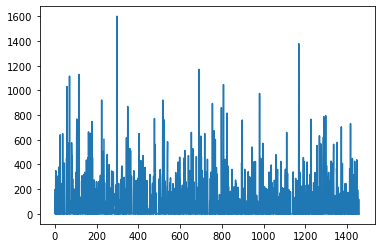

In [82]:
#27th Column - Contains Nulls
houses['MasVnrArea'].plot()

In [83]:
houses['MasVnrArea'].fillna(houses['MasVnrArea'].median(), inplace=True)

In [84]:
#28th Column
houses['ExterQual'].value_counts()

TA    906
Gd    488
Ex     52
Fa     14
Name: ExterQual, dtype: int64

In [85]:
houses['ExterQual'] = houses ['ExterQual'].apply (lambda x: '_'.join ([x, 'ExterQual']))

ext = pd.get_dummies(houses['ExterQual'], drop_first=True)
houses = pd.concat ([houses, ext], axis=1)

houses.drop (columns=['ExterQual'], axis=1, inplace=True)

In [86]:
#29th Column
houses['ExterCond'].value_counts()

TA    1282
Gd     146
Fa      28
Ex       3
Po       1
Name: ExterCond, dtype: int64

In [87]:
houses['ExterCond'] = houses ['ExterCond'].apply (lambda x: '_'.join ([x, 'ExterCond']))

ext = pd.get_dummies(houses['ExterCond'], drop_first=True)
houses = pd.concat ([houses, ext], axis=1)

houses.drop (columns=['ExterCond'], axis=1, inplace=True)

In [88]:
#30th Column
houses['Foundation'].value_counts()

PConc     647
CBlock    634
BrkTil    146
Slab       24
Stone       6
Wood        3
Name: Foundation, dtype: int64

In [89]:
houses['Foundation'] = houses ['Foundation'].apply (lambda x: '_'.join ([x, 'Foundation']))

fnd = pd.get_dummies(houses['Foundation'], drop_first=True)
houses = pd.concat ([houses, fnd], axis=1)

houses.drop (columns=['Foundation'], axis=1, inplace=True)

In [90]:
houses.shape

(1460, 182)

#### <font color=red> Columns 21 to 30 processed </font>

In [91]:
#31st Column
houses['BsmtQual'].value_counts()

TA    649
Gd    618
Ex    121
Fa     35
Name: BsmtQual, dtype: int64

In [92]:
houses['TA_BsmtQual'] = houses['BsmtQual'].apply (lambda x: 1 if x == 'TA' else 0)
houses['Gd_BsmtQual'] = houses['BsmtQual'].apply (lambda x: 1 if x == 'Gd' else 0)
houses['Ex_BsmtQual'] = houses['BsmtQual'].apply (lambda x: 1 if x == 'Ex' else 0)
houses['Fa_BsmtQual'] = houses['BsmtQual'].apply (lambda x: 1 if x == 'Fa' else 0)

houses.drop (columns=['BsmtQual'], axis=1, inplace=True)

In [93]:
#32nd Column
houses['BsmtCond'].value_counts()

TA    1311
Gd      65
Fa      45
Po       2
Name: BsmtCond, dtype: int64

In [94]:
houses['TA_BsmtCond'] = houses['BsmtCond'].apply (lambda x: 1 if x == 'TA' else 0)
houses['Gd_BsmtCond'] = houses['BsmtCond'].apply (lambda x: 1 if x == 'Gd' else 0)
houses['Po_BsmtCond'] = houses['BsmtCond'].apply (lambda x: 1 if x == 'Po' else 0)
houses['Fa_BsmtCond'] = houses['BsmtCond'].apply (lambda x: 1 if x == 'Fa' else 0)

houses.drop (columns=['BsmtCond'], axis=1, inplace=True)

In [95]:
#33rd Column
houses['BsmtExposure'].value_counts()

No    953
Av    221
Gd    134
Mn    114
Name: BsmtExposure, dtype: int64

In [96]:
houses['No_BsmtExposure'] = houses['BsmtExposure'].apply (lambda x: 1 if x == 'No' else 0)
houses['Av_BsmtExposure'] = houses['BsmtExposure'].apply (lambda x: 1 if x == 'Av' else 0)
houses['Gd_BsmtExposure'] = houses['BsmtExposure'].apply (lambda x: 1 if x == 'Gd' else 0)
houses['Mn_BsmtExposure'] = houses['BsmtExposure'].apply (lambda x: 1 if x == 'Mn' else 0)

houses.drop (columns=['BsmtExposure'], axis=1, inplace=True)

In [97]:
#34th Column
houses['BsmtFinType1'].value_counts()

Unf    430
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
Name: BsmtFinType1, dtype: int64

In [98]:
#36th Column
houses['BsmtFinType2'].value_counts()

Unf    1256
Rec      54
LwQ      46
BLQ      33
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype: int64

In [99]:
houses['Unf_BsmtFinType1'] = houses['BsmtFinType1'].apply (lambda x: 1 if x == 'Unf' else 0)
houses['GLQ_BsmtFinType1'] = houses['BsmtFinType1'].apply (lambda x: 1 if x == 'GLQ' else 0)
houses['ALQ_BsmtFinType1'] = houses['BsmtFinType1'].apply (lambda x: 1 if x == 'ALQ' else 0)
houses['BLQ_BsmtFinType1'] = houses['BsmtFinType1'].apply (lambda x: 1 if x == 'BLQ' else 0)
houses['Rec_BsmtFinType1'] = houses['BsmtFinType1'].apply (lambda x: 1 if x == 'Rec' else 0)
houses['LwQ_BsmtFinType1'] = houses['BsmtFinType1'].apply (lambda x: 1 if x == 'LwQ' else 0)

houses.drop (columns=['BsmtFinType1'], axis=1, inplace=True)

<AxesSubplot:>

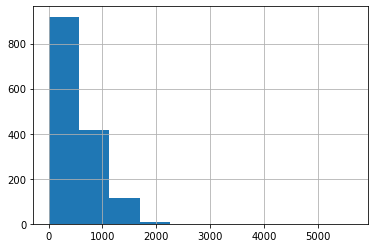

In [100]:
#35th Column
houses['BsmtFinSF1'].hist()

In [101]:
houses['Unf_BsmtFinType2'] = houses['BsmtFinType2'].apply (lambda x: 1 if x == 'Unf' else 0)
houses['GLQ_BsmtFinType2'] = houses['BsmtFinType2'].apply (lambda x: 1 if x == 'GLQ' else 0)
houses['ALQ_BsmtFinType2'] = houses['BsmtFinType2'].apply (lambda x: 1 if x == 'ALQ' else 0)
houses['BLQ_BsmtFinType2'] = houses['BsmtFinType2'].apply (lambda x: 1 if x == 'BLQ' else 0)
houses['Rec_BsmtFinType2'] = houses['BsmtFinType2'].apply (lambda x: 1 if x == 'Rec' else 0)
houses['LwQ_BsmtFinType2'] = houses['BsmtFinType2'].apply (lambda x: 1 if x == 'LwQ' else 0)

houses.drop (columns=['BsmtFinType2'], axis=1, inplace=True)

<AxesSubplot:>

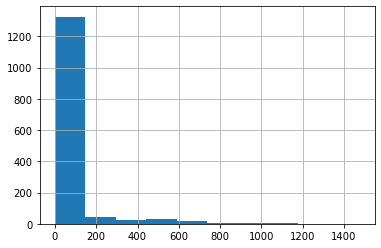

In [102]:
#37th Column
houses['BsmtFinSF2'].hist()

<AxesSubplot:>

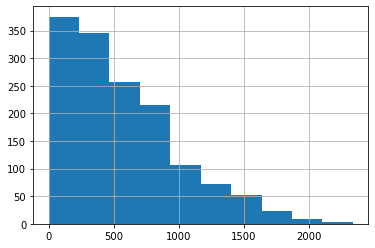

In [103]:
#38th Column
houses['BsmtUnfSF'].hist()

<AxesSubplot:>

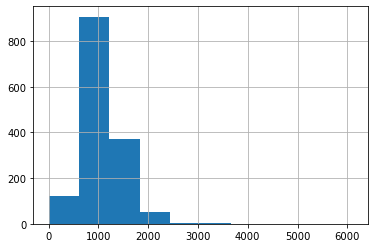

In [104]:
#39th Column
houses['TotalBsmtSF'].hist()

In [105]:
#40th Column
houses['Heating'].value_counts()

GasA     1428
GasW       18
Grav        7
Wall        4
OthW        2
Floor       1
Name: Heating, dtype: int64

In [106]:
100*1428/1460

97.8082191780822

In [107]:
houses['Heating'] = houses ['Heating'].apply (lambda x: '_'.join ([x, 'Heating']))

heat = pd.get_dummies(houses['Heating'], drop_first=False)
houses = pd.concat ([houses, heat], axis=1)

#Removing these columns as about 98% rows contain the same value
single_value_columns.extend (['GasA_Heating', 'GasW_Heating', 'Grav_Heating', 'Wall_Heating', 'OthW_Heating', 'Floor_Heating'])

houses.drop (columns=['Heating'], axis=1, inplace=True)

In [108]:
houses.shape

(1460, 206)

#### <font color=red> Columns 31 to 40 processed </font>

In [109]:
#41st Column
houses['HeatingQC'].value_counts()

Ex    741
TA    428
Gd    241
Fa     49
Po      1
Name: HeatingQC, dtype: int64

In [110]:
houses['HeatingQC'] = houses ['HeatingQC'].apply (lambda x: '_'.join ([x, 'HeatingQC']))

heat = pd.get_dummies(houses['HeatingQC'], drop_first=True)
houses = pd.concat ([houses, heat], axis=1)

houses.drop (columns=['HeatingQC'], axis=1, inplace=True)

In [111]:
#42nd Column
houses['CentralAir'].value_counts()

Y    1365
N      95
Name: CentralAir, dtype: int64

In [112]:
houses['CentralAir'] = houses ['CentralAir'].map ({'Y':1, 'N':0})

In [113]:
#43rd Column
houses['Electrical'].value_counts()

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [114]:
houses['Electrical_SBrkr'] = houses['Electrical'].apply (lambda x: 1 if x == 'SBrkr' else 0)
houses['Electrical_FuseA'] = houses['Electrical'].apply (lambda x: 1 if x == 'FuseA' else 0)
houses['Electrical_FuseF'] = houses['Electrical'].apply (lambda x: 1 if x == 'FuseF' else 0)
houses['Electrical_FuseP'] = houses['Electrical'].apply (lambda x: 1 if x == 'FuseP' else 0)
houses['Electrical_Mix']   = houses['Electrical'].apply (lambda x: 1 if x == 'Mix' else 0)

houses.drop (columns=['Electrical'], axis=1, inplace=True)

<AxesSubplot:>

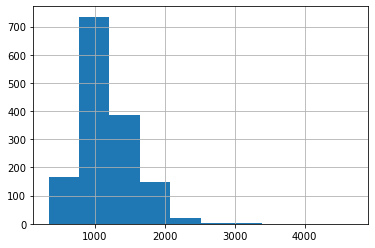

In [115]:
#44th Column
houses['1stFlrSF'].hist()

<AxesSubplot:>

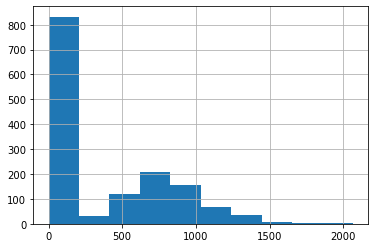

In [116]:
#45th Column
houses['2ndFlrSF'].hist()

In [117]:
#46th Column
houses['LowQualFinSF'].value_counts()

0      1434
80        3
360       2
205       1
479       1
397       1
514       1
120       1
481       1
232       1
53        1
515       1
156       1
473       1
420       1
390       1
371       1
392       1
144       1
572       1
528       1
234       1
513       1
384       1
Name: LowQualFinSF, dtype: int64

In [118]:
100*1434/1460

98.21917808219177

In [119]:
#Dropping this column as 98% contain the same value
houses.drop (columns=['LowQualFinSF'], axis=1, inplace=True)

<AxesSubplot:>

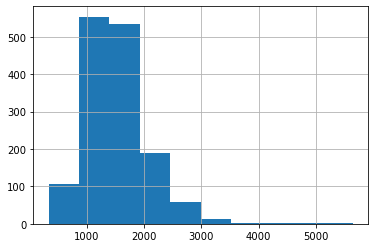

In [120]:
#47th Column
houses['GrLivArea'].hist()

In [121]:
#48th Column
houses['BsmtFullBath'].value_counts()

0    856
1    588
2     15
3      1
Name: BsmtFullBath, dtype: int64

In [122]:
#49th Column
houses['BsmtHalfBath'].value_counts()

0    1378
1      80
2       2
Name: BsmtHalfBath, dtype: int64

In [123]:
#50th Column
houses['FullBath'].value_counts()

2    768
1    650
3     33
0      9
Name: FullBath, dtype: int64

In [124]:
houses.shape

(1460, 212)

#### <font color=red> Columns 41 to 50 processed </font>

In [125]:
#51st Column
houses['HalfBath'].value_counts()

0    913
1    535
2     12
Name: HalfBath, dtype: int64

In [126]:
#52nd Column
houses['BedroomAbvGr'].value_counts()

3    804
2    358
4    213
1     50
5     21
6      7
0      6
8      1
Name: BedroomAbvGr, dtype: int64

In [127]:
#53rd Column
houses['KitchenAbvGr'].value_counts()

1    1392
2      65
3       2
0       1
Name: KitchenAbvGr, dtype: int64

In [128]:
#54th Column
houses['KitchenQual'].value_counts()

TA    735
Gd    586
Ex    100
Fa     39
Name: KitchenQual, dtype: int64

In [129]:
houses['KitchenQual'] = houses ['KitchenQual'].apply (lambda x: '_'.join ([x, 'KitchenQual']))

kQ = pd.get_dummies(houses['KitchenQual'], drop_first=True)
houses = pd.concat ([houses, kQ], axis=1)

houses.drop (columns=['KitchenQual'], axis=1, inplace=True)

In [130]:
#55th Column
houses['TotRmsAbvGrd'].value_counts()

6     402
7     329
5     275
8     187
4      97
9      75
10     47
11     18
3      17
12     11
2       1
14      1
Name: TotRmsAbvGrd, dtype: int64

In [131]:
#56th Column
houses['Functional'].value_counts()

Typ     1360
Min2      34
Min1      31
Mod       15
Maj1      14
Maj2       5
Sev        1
Name: Functional, dtype: int64

In [132]:
houses['Functional'] = houses ['Functional'].apply (lambda x: '_'.join ([x, 'Functional']))

func = pd.get_dummies(houses['Functional'], drop_first=True)
houses = pd.concat ([houses, func], axis=1)

houses.drop (columns=['Functional'], axis=1, inplace=True)

In [133]:
#57th Column
houses['Fireplaces'].value_counts()

0    690
1    650
2    115
3      5
Name: Fireplaces, dtype: int64

In [134]:
#58th Column
houses['FireplaceQu'].value_counts()

Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64

In [135]:
100*690/1460

47.26027397260274

In [136]:
#Nearly 50% of the column contains null values - means they don't have a fireplace

In [137]:
houses['Gd_FireplaceQu'] = houses['FireplaceQu'].apply (lambda x: 1 if x == 'Gd' else 0)
houses['TA_FireplaceQu'] = houses['FireplaceQu'].apply (lambda x: 1 if x == 'TA' else 0)
houses['Fa_FireplaceQu'] = houses['FireplaceQu'].apply (lambda x: 1 if x == 'Fa' else 0)
houses['Ex_FireplaceQu'] = houses['FireplaceQu'].apply (lambda x: 1 if x == 'Ex' else 0)
houses['Po_FireplaceQu'] = houses['FireplaceQu'].apply (lambda x: 1 if x == 'Po' else 0)

houses.drop (columns=['FireplaceQu'], axis=1, inplace=True)

In [138]:
#59th Column
houses['GarageType'].value_counts()

Attchd     870
Detchd     387
BuiltIn     88
Basment     19
CarPort      9
2Types       6
Name: GarageType, dtype: int64

In [139]:
houses['Attchd_Garage']  = houses['GarageType'].apply (lambda x: 1 if x == 'Attchd' else 0)
houses['Detchd_Garage']  = houses['GarageType'].apply (lambda x: 1 if x == 'Detchd' else 0)
houses['BuiltIn_Garage'] = houses['GarageType'].apply (lambda x: 1 if x == 'BuiltIn' else 0)
houses['Basment_Garage'] = houses['GarageType'].apply (lambda x: 1 if x == 'Basment' else 0)
houses['CarPort_Garage'] = houses['GarageType'].apply (lambda x: 1 if x == 'CarPort' else 0)
houses['2Types_Garage']  = houses['GarageType'].apply (lambda x: 1 if x == '2Types' else 0)

houses.drop (columns=['GarageType'], axis=1, inplace=True)

<AxesSubplot:>

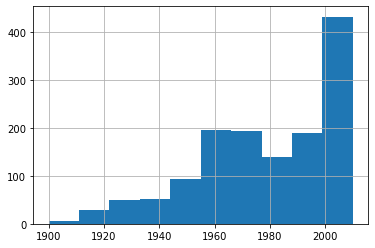

In [140]:
#60th Column
houses['GarageYrBlt'].hist()

In [141]:
#Dropping above column, as it is a time series data, and it should not affect the price of the house.
#There are a few null values in this column. Instead of deleting rows with null values, its better to delete this column
houses.drop (columns=['GarageYrBlt'], axis=1, inplace=True)

In [142]:
houses.shape

(1460, 227)

#### <font color=red> Columns 51 to 60 processed </font>

In [143]:
#61st Column
houses['GarageFinish'].value_counts()

Unf    605
RFn    422
Fin    352
Name: GarageFinish, dtype: int64

In [144]:
houses['Unf_Garage'] = houses['GarageFinish'].apply (lambda x: 1 if x == 'Unf' else 0)
houses['RFn_Garage'] = houses['GarageFinish'].apply (lambda x: 1 if x == 'RFn' else 0)
houses['Fin_Garage'] = houses['GarageFinish'].apply (lambda x: 1 if x == 'Fin' else 0)

houses.drop (columns=['GarageFinish'], axis=1, inplace=True)

In [145]:
#62nd Column
houses['GarageCars'].value_counts()

2    824
1    369
3    181
0     81
4      5
Name: GarageCars, dtype: int64

<AxesSubplot:>

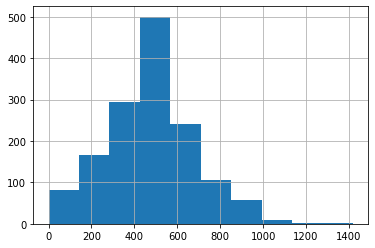

In [146]:
#63rd Column
houses['GarageArea'].hist()

In [147]:
#64th Column
houses['GarageQual'].value_counts()

TA    1311
Fa      48
Gd      14
Ex       3
Po       3
Name: GarageQual, dtype: int64

In [148]:
houses['TA_GarageQual'] = houses['GarageQual'].apply (lambda x: 1 if x == 'TA' else 0)
houses['Fa_GarageQual'] = houses['GarageQual'].apply (lambda x: 1 if x == 'Fa' else 0)
houses['Gd_GarageQual'] = houses['GarageQual'].apply (lambda x: 1 if x == 'Gd' else 0)
houses['Ex_GarageQual'] = houses['GarageQual'].apply (lambda x: 1 if x == 'Ex' else 0)
houses['Po_GarageQual'] = houses['GarageQual'].apply (lambda x: 1 if x == 'Po' else 0)

houses.drop (columns=['GarageQual'], axis=1, inplace=True)

In [149]:
#65th Column
houses['GarageCond'].value_counts()

TA    1326
Fa      35
Gd       9
Po       7
Ex       2
Name: GarageCond, dtype: int64

In [150]:
houses['TA_GarageCond'] = houses['GarageCond'].apply (lambda x: 1 if x == 'TA' else 0)
houses['Fa_GarageCond'] = houses['GarageCond'].apply (lambda x: 1 if x == 'Fa' else 0)
houses['Gd_GarageCond'] = houses['GarageCond'].apply (lambda x: 1 if x == 'Gd' else 0)
houses['Ex_GarageCond'] = houses['GarageCond'].apply (lambda x: 1 if x == 'Ex' else 0)
houses['Po_GarageCond'] = houses['GarageCond'].apply (lambda x: 1 if x == 'Po' else 0)

houses.drop (columns=['GarageCond'], axis=1, inplace=True)

In [151]:
#66th Column
houses['PavedDrive'].value_counts()

Y    1340
N      90
P      30
Name: PavedDrive, dtype: int64

In [152]:
#In the above data, it seems the value P is the same as Y.
houses['PavedDriveway'] = houses['PavedDrive'].apply (lambda x: 1 if x == 'Y' else 0)
houses['GravlDriveway'] = houses['PavedDrive'].apply (lambda x: 1 if x == 'N' else 0)

houses.drop (columns=['PavedDrive'], axis=1, inplace=True)

<AxesSubplot:>

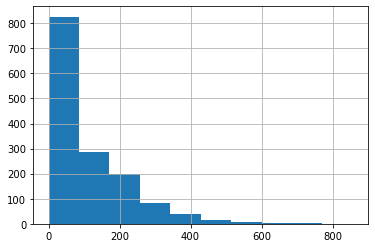

In [153]:
#67th Column
houses['WoodDeckSF'].hist()

<AxesSubplot:>

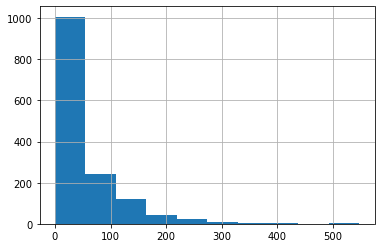

In [154]:
#68th Column
houses['OpenPorchSF'].hist()

<AxesSubplot:>

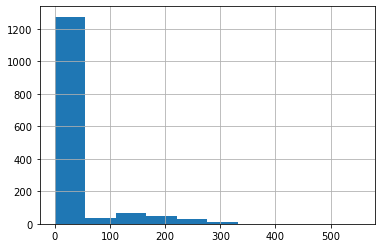

In [155]:
#69th Column
houses['EnclosedPorch'].hist()

In [156]:
#70th Column
houses['3SsnPorch'].value_counts()

0      1436
168       3
144       2
180       2
216       2
290       1
153       1
96        1
23        1
162       1
182       1
196       1
320       1
245       1
238       1
508       1
140       1
130       1
407       1
304       1
Name: 3SsnPorch, dtype: int64

In [157]:
100*1436/1460

98.35616438356165

In [158]:
#Dropping this column as 98% contain the same value
houses.drop (columns=['3SsnPorch'], axis=1, inplace=True)

In [159]:
houses.shape

(1460, 237)

#### <font color=red> Columns 61 to 70 processed </font>

<AxesSubplot:>

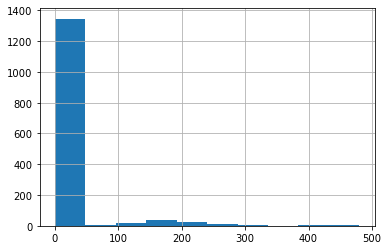

In [160]:
#71st Column
houses['ScreenPorch'].hist()

In [161]:
#72nd Column
houses['PoolArea'].value_counts()

0      1453
512       1
648       1
576       1
555       1
480       1
519       1
738       1
Name: PoolArea, dtype: int64

In [162]:
100*1453/1460

99.52054794520548

In [163]:
#73rd Column
houses['PoolQC'].value_counts()

Gd    3
Ex    2
Fa    2
Name: PoolQC, dtype: int64

In [164]:
# Dropping above 2 columns and keeping only a single column which states if pool exists or not
houses['Pool'] = houses['PoolArea'].apply (lambda x: 0 if x==0 else 1)

houses.drop (columns=['PoolQC', 'PoolArea'], axis=1, inplace=True)

In [165]:
#74th Column
houses['Fence'].value_counts()

MnPrv    157
GdPrv     59
GdWo      54
MnWw      11
Name: Fence, dtype: int64

In [166]:
houses['MnPrv_Fence'] = houses['Fence'].apply (lambda x: 1 if x == 'MnPrv' else 0)
houses['GdPrv_Fence'] = houses['Fence'].apply (lambda x: 1 if x == 'GdPrv' else 0)
houses['GdWo_Fence']  = houses['Fence'].apply (lambda x: 1 if x == 'GdWw' else 0)
houses['MnWw_Fence']  = houses['Fence'].apply (lambda x: 1 if x == 'MnWw' else 0)

houses.drop (columns=['Fence'], axis=1, inplace=True)

In [167]:
#75th Column
houses['MiscFeature'].value_counts()

Shed    49
Gar2     2
Othr     2
TenC     1
Name: MiscFeature, dtype: int64

In [168]:
houses['MiscFeature'].isna().sum()

1406

In [169]:
#Most values are null

#Instead of dividing the features into separate columns, we can keep a single feature - called MiscFeature. 
#Replace all non-null values with 1 and the rest as zero

houses['MiscFeature'] = houses['MiscFeature'].fillna (0)
houses['MiscFeature'] = houses['MiscFeature'].apply (lambda x: 0 if x==0 else 1)

In [170]:
#76th Column
houses['MiscVal'][houses['MiscVal'] != 0].value_counts()

400      11
500       8
700       5
450       4
2000      4
600       4
1200      2
480       2
15500     1
800       1
350       1
3500      1
1300      1
54        1
620       1
560       1
1400      1
8300      1
1150      1
2500      1
Name: MiscVal, dtype: int64

In [171]:
#Add Misc Value to Sale Price and then drop this column
houses['SalePrice'] = houses['SalePrice'] + houses['MiscVal']

In [172]:
houses.drop (columns=['MiscVal'], axis=1, inplace=True)

In [173]:
#77th Column
houses['MoSold'].value_counts()

6     253
7     234
5     204
4     141
8     122
3     106
10     89
11     79
9      63
12     59
1      58
2      52
Name: MoSold, dtype: int64

In [174]:
#Dropping this column as it is past history which should not impact price
houses.drop (columns=['MoSold'], axis=1, inplace=True)

In [175]:
#78th Column
houses['YrSold'].value_counts()

2009    338
2007    329
2006    314
2008    304
2010    175
Name: YrSold, dtype: int64

In [176]:
#Dropping this column as it is past history which should not impact price
houses.drop (columns=['YrSold'], axis=1, inplace=True)

In [177]:
#79th Column
houses['SaleType'].value_counts()

WD       1267
New       122
COD        43
ConLD       9
ConLI       5
ConLw       5
CWD         4
Oth         3
Con         2
Name: SaleType, dtype: int64

In [178]:
#Dropping this column as it is past history which should not impact price
houses.drop (columns=['SaleType'], axis=1, inplace=True)

In [179]:
#80th Column
houses['SaleCondition'].value_counts()

Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
Name: SaleCondition, dtype: int64

In [180]:
#Dropping this column as it is past history which should not impact price
houses.drop (columns=['SaleCondition'], axis=1, inplace=True)

<AxesSubplot:>

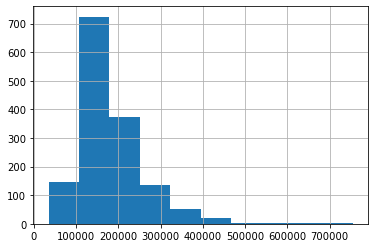

In [181]:
#81st Column - LAST
houses['SalePrice'].hist()

#### <font color=red> Columns 71 to 81 processed - FINISHED EDA </font>

#### <font color=blue> Step 3.3: </font> Perform a sanity check on the dataset

In [182]:
houses.loc[:, houses.isna().any()].isna().sum()

Series([], dtype: float64)

In [183]:
houses.shape

(1460, 234)

In [184]:
houses.head()

,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,CentralAir,...,Gd_GarageCond,Ex_GarageCond,Po_GarageCond,PavedDriveway,GravlDriveway,Pool,MnPrv_Fence,GdPrv_Fence,GdWo_Fence,MnWw_Fence
0,65.0,8450,7,5,196.0,706,0,150,856,1,...,0,0,0,1,0,0,0,0,0,0
1,80.0,9600,6,8,0.0,978,0,284,1262,1,...,0,0,0,1,0,0,0,0,0,0
2,68.0,11250,7,5,162.0,486,0,434,920,1,...,0,0,0,1,0,0,0,0,0,0
3,60.0,9550,7,5,0.0,216,0,540,756,1,...,0,0,0,1,0,0,0,0,0,0
4,84.0,14260,8,5,350.0,655,0,490,1145,1,...,0,0,0,1,0,0,0,0,0,0


In [185]:
houses.info (verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 234 columns):
 #    Column                       Dtype  
---   ------                       -----  
 0    LotFrontage                  float64
 1    LotArea                      int64  
 2    OverallQual                  int64  
 3    OverallCond                  int64  
 4    MasVnrArea                   float64
 5    BsmtFinSF1                   int64  
 6    BsmtFinSF2                   int64  
 7    BsmtUnfSF                    int64  
 8    TotalBsmtSF                  int64  
 9    CentralAir                   int64  
 10   1stFlrSF                     int64  
 11   2ndFlrSF                     int64  
 12   GrLivArea                    int64  
 13   BsmtFullBath                 int64  
 14   BsmtHalfBath                 int64  
 15   FullBath                     int64  
 16   HalfBath                     int64  
 17   BedroomAbvGr                 int64  
 18   KitchenAbvGr              

#### <font color=blue> Step 3.4: </font> Remove Columns that should not be considered for analysis
> <font color=red> These are columns where more than 95% data is a single value </font>

In [186]:
all_X_cols = list (houses.columns)
all_X_cols.remove ('SalePrice')

In [187]:
single_value_columns

['Paved_Street',
 'AllPub_Utilities',
 'CompShg_RoofMatl',
 'Tar&Grv_RoofMatl',
 'WdShngl_RoofMatl',
 'WdShake_RoofMatl',
 'Metal_RoofMatl',
 'Membran_RoofMatl',
 'Roll_RoofMatl',
 'ClyTile_RoofMatl',
 'GasA_Heating',
 'GasW_Heating',
 'Grav_Heating',
 'Wall_Heating',
 'OthW_Heating',
 'Floor_Heating']

In [188]:
reduced_X_cols = copy.deepcopy (all_X_cols)

for c in single_value_columns:
    reduced_X_cols.remove (c)
    
len (reduced_X_cols)

217

#### <font color=blue> Step 4: </font> Prepare Data for Linear Regression

#### <font color=blue> Step 4.1: </font> Remove outliers

In [189]:
original_houses_data = copy.deepcopy (houses)

#### <font color=blue> Step 4.2: </font> Test Train Split

In [190]:
houses = copy.deepcopy (original_houses_data)

In [191]:
X_cols = all_X_cols

In [192]:
houses_train, houses_test = tts (houses, train_size=0.70, random_state=1)

In [193]:
print (houses_train.shape, houses_test.shape)

(1021, 234) (439, 234)


#### <font color=blue> Step 4.3: </font> Scale Values

In [194]:
mms = MinMaxScaler()

In [195]:
houses_train [X_cols] = mms.fit_transform (houses_train[X_cols])
houses_test  [X_cols] = mms.transform     (houses_test [X_cols])

#### <font color=blue> Step 4.4: </font> Separate X and y

In [196]:
y      = houses_train.pop ('SalePrice')
y_test = houses_test.pop  ('SalePrice')

In [197]:
X      = houses_train[X_cols]
X_test = houses_test [X_cols]

In [198]:
print (X.shape, X_test.shape)

(1021, 233) (439, 233)


#### <font color=blue> Step 4.5: </font> Create Dictionaries to store various regression data

In [199]:
#For storing R2 score, RSS, Mean Squared Error, Root Mean Squared Error - of each model
error_scores = {}

In [200]:
#For storing coefficient values - of each model
coef_df = pd.DataFrame (index=X_cols, columns=['Poly', 'Poly_SK', 'Ridge', 'Lasso', 'Ridge2', 'Lasso2'])

In [201]:
#For storing residuals of each model
residuals = {}

#### <font color=blue> Step 5: </font> Modelling

#### <font color=blue> Step 5.1: </font> Ordinary Multi-Linear Regression

#### <font color=blue> Step 5.1.1: </font> StatsModels OLS

In [202]:
lr_model = sm_api.OLS (y, X).fit()
coef_df ['Poly'] = lr_model.params

#### Predict on <font color=blue> Training </font> Data and check RSS and scatter map

In [203]:
#TRAINING DATA

#Predict Sales Price
y_pred = lr_model.predict (X)

#Calculate R2, RSS, MSE, RMSE
r2 = r2_score (y, y_pred).round (4)
rss = np.sum (np.square (y - y_pred)).round (4)
mse = mean_squared_error (y, y_pred).round (4)
rmse = (mse**0.5).round (4)
percent_rmse = round(100 * rmse / mean_SalePrice, 2) 

#Store above error scores in dictionary
error_scores ['Poly  - Train Data'] = ('R2_Score: %5.4f, Percent RMSE: %5.2f' % (r2, percent_rmse))

#Store residuals in dictionary - for residual analysis
residuals ['Poly-Train'] = y - y_pred

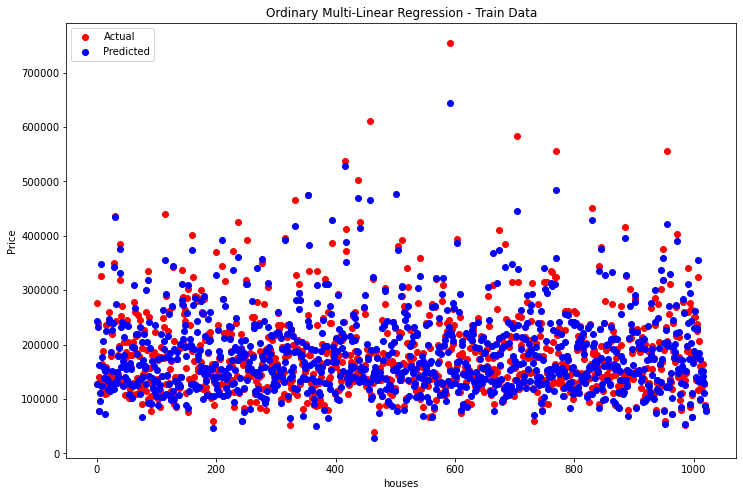

In [204]:
#Compare Actual vs Predicted Target using a scatter map
plt.figure (figsize=(12,8))

x_len = len (X.index)
Xs = np.arange (x_len)

plt.scatter (Xs, y, color='red')
plt.scatter (Xs, y_pred, color='blue')

plt.title  ('Ordinary Multi-Linear Regression - Train Data')
plt.xlabel ('houses')
plt.ylabel ('Price')
plt.legend (['Actual', 'Predicted'], loc='upper left')

plt.show()

#### Predict on <font color=blue> Test </font> Data and check RSS and scatter map

In [205]:
#TEST DATA

#Predict Sales Price
y_pred_test = lr_model.predict (X_test)

#Calculate R2, RSS, MSE, RMSE
r2 = r2_score (y_test, y_pred_test).round (4)
rss = np.sum (np.square (y_test - y_pred_test)).round (4)
mse = mean_squared_error (y_test, y_pred_test).round (4)
rmse = (mse**0.5).round (4)
percent_rmse = round(100 * rmse / mean_SalePrice, 2) 

#Store above error scores in dictionary
error_scores ['Poly  - Test Data '] = ('R2_Score: %5.4f, Percent RMSE: %5.2f' % (r2, percent_rmse))

#Store residuals in dictionary - for residual analysis
residuals ['Poly-Test'] = y_test - y_pred_test

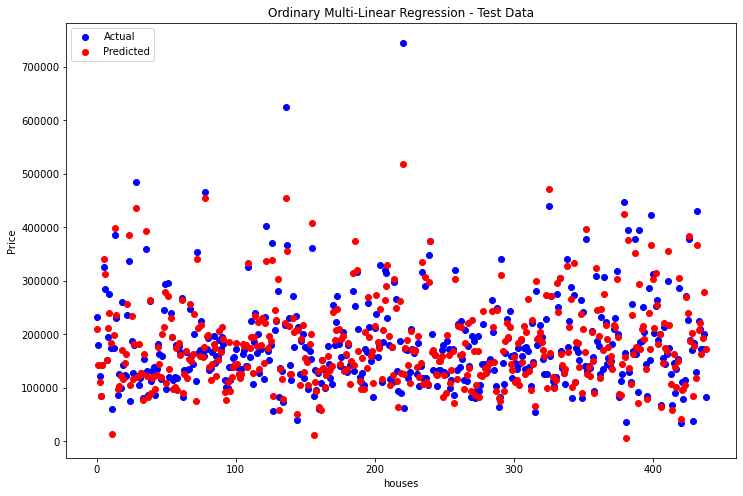

In [206]:
#Compare Actual vs Predicted Target using a scatter map
plt.figure (figsize=(12,8))

x_len = len (X_test.index)
Xs = np.arange (x_len)

plt.scatter (Xs, y_test, color='blue')
plt.scatter (Xs, y_pred_test, color='red')

plt.title  ('Ordinary Multi-Linear Regression - Test Data')
plt.xlabel ('houses')
plt.ylabel ('Price')
plt.legend (['Actual', 'Predicted'], loc='upper left')

plt.show()

In [207]:
error_scores

{'Poly  - Train Data': 'R2_Score: 0.9197, Percent RMSE: 12.07',
 'Poly  - Test Data ': 'R2_Score: 0.8798, Percent RMSE: 16.20'}

#### <font color=blue> Step 5.1.2: </font> SK Learn LinearRegression

In [208]:
lr_model_sk = LinearRegression()
lr_model_sk.fit (X, y)
coef_df ['Poly_SK'] = lr_model_sk.coef_

In [209]:
#TRAINING DATA

#Predict Sales Price
y_pred = lr_model_sk.predict (X)

#Calculate R2, RSS, MSE, RMSE
r2 = r2_score (y, y_pred).round (4)
rss = np.sum (np.square (y - y_pred)).round (4)
mse = mean_squared_error (y, y_pred).round (4)
rmse = (mse**0.5).round (4)
percent_rmse = round(100 * rmse / mean_SalePrice, 2) 

#Store above error scores in dictionary
error_scores ['PolySK- Train Data'] = ('R2_Score: %5.4f, Percent RMSE: %5.2f' % (r2, percent_rmse))

#Store residuals in dictionary - for residual analysis
residuals ['PolySK-Train'] = y - y_pred

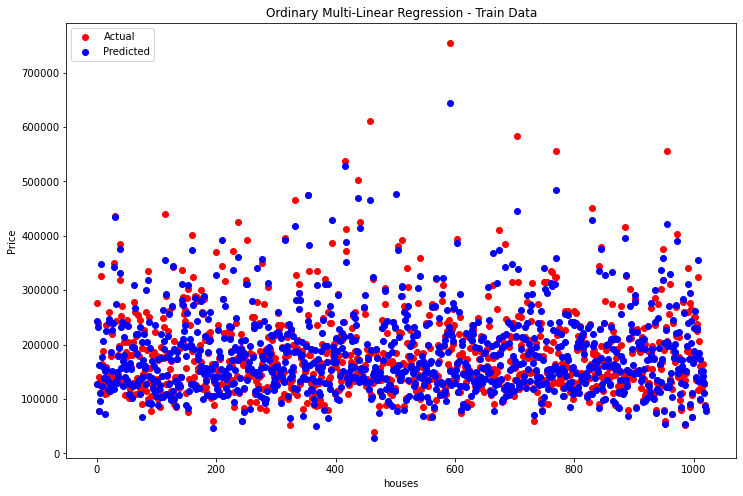

In [210]:
#Compare Actual vs Predicted Target using a scatter map
plt.figure (figsize=(12,8))

x_len = len (X.index)
Xs = np.arange (x_len)

plt.scatter (Xs, y, color='red')
plt.scatter (Xs, y_pred, color='blue')

plt.title  ('Ordinary Multi-Linear Regression - Train Data')
plt.xlabel ('houses')
plt.ylabel ('Price')
plt.legend (['Actual', 'Predicted'], loc='upper left')

plt.show()

In [211]:
#TEST DATA

#Predict Sales Price
y_pred_test = lr_model_sk.predict (X_test)

#Calculate R2, RSS, MSE, RMSE
r2 = r2_score (y_test, y_pred_test).round (4)
rss = np.sum (np.square (y_test - y_pred_test)).round (4)
mse = mean_squared_error (y_test, y_pred_test).round (4)
rmse = (mse**0.5).round (4)
percent_rmse = round(100 * rmse / mean_SalePrice, 2) 

#Store above error scores in dictionary
error_scores ['PolySK- Test Data '] = ('R2_Score: %5.4f, Percent RMSE: %5.2f' % (r2, percent_rmse))

#Store residuals in dictionary - for residual analysis
residuals ['PolySK-Test'] = y_test - y_pred_test

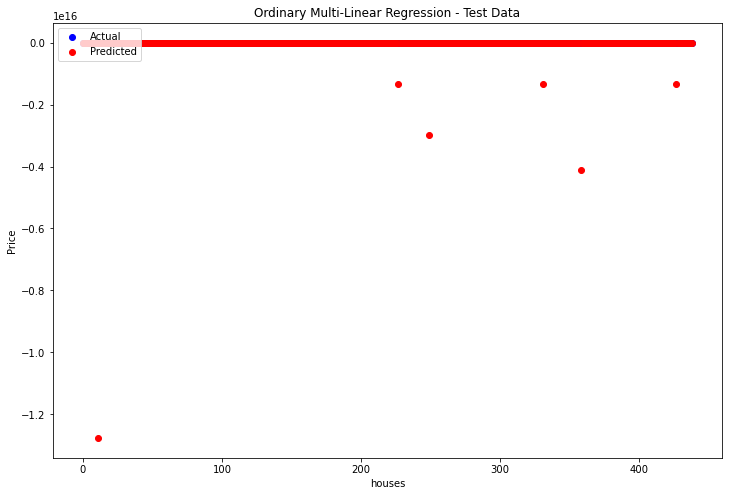

In [212]:
#Compare Actual vs Predicted Target using a scatter map
plt.figure (figsize=(12,8))

x_len = len (X_test.index)
Xs = np.arange (x_len)

plt.scatter (Xs, y_test, color='blue')
plt.scatter (Xs, y_pred_test, color='red')

plt.title  ('Ordinary Multi-Linear Regression - Test Data')
plt.xlabel ('houses')
plt.ylabel ('Price')
plt.legend (['Actual', 'Predicted'], loc='upper left')

plt.show()

In [213]:
error_scores

{'Poly  - Train Data': 'R2_Score: 0.9197, Percent RMSE: 12.07',
 'Poly  - Test Data ': 'R2_Score: 0.8798, Percent RMSE: 16.20',
 'PolySK- Train Data': 'R2_Score: 0.9197, Percent RMSE: 12.07',
 'PolySK- Test Data ': 'R2_Score: -61942855914969284608.0000, Percent RMSE: 367715441259.57'}

#### <font color=blue> Step 5.2: </font> Get the best alpha for Ridge and Lasso - using K-fold Cross-Validation

In [214]:
from sklearn.model_selection import KFold, GridSearchCV

In [215]:
#Create a parameter list of all possible lambda values for Ridge and Lass cost function
#K-fold cross validation will be used for finding the best value of alpha
lambdas = {'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.05, 
                     0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 
                     1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0,
                     10, 20, 50, 100, 500, 1000]}

In [216]:
#Prepare for 5-fold cross-validation dataset
folds = KFold (n_splits = 5, shuffle = True, random_state = 10)

#### <font color=blue> Step 5.2.1: </font> Ridge

In [217]:
#Use Grid Search for finding the best value of alpha (called lambda in the Cost Function) for Ridge regression
model_cv = GridSearchCV (estimator=Ridge(),
                         param_grid=lambdas,
                         scoring='neg_mean_absolute_error',
                         cv=folds,
                         return_train_score=True,
                         verbose=1
                        )

In [218]:
model_cv.fit (X, y)

Fitting 5 folds for each of 29 candidates, totalling 145 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=10, shuffle=True),
             estimator=Ridge(),
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.2,
                                   0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0,
                                   3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10, 20,
                                   50, 100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [219]:
model_cv.best_params_

{'alpha': 5.0}

In [220]:
temp_alpha = model_cv.best_params_ ['alpha']
step = 0.1 if temp_alpha <= 10.0 else 1.0

new_alpha_list = [round (i, 1) for i in np.arange (temp_alpha-10.0*step, temp_alpha+10.0*step, step)]
lambdas_rev = {'alpha': new_alpha_list}

#Use Grid Search for finding the best value of alpha (called lambda in the Cost Function) for Ridge regression
model_cv = GridSearchCV (estimator=Ridge(),
                         param_grid=lambdas_rev,
                         scoring='neg_mean_absolute_error',
                         cv=folds,
                         return_train_score=True,
                         verbose=1
                        )

model_cv.fit (X, y)

model_cv.best_params_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


{'alpha': 5.3}

In [221]:
ridge_alpha = model_cv.best_params_['alpha']

In [222]:
ridge_model  = Ridge (alpha = ridge_alpha)
ridge_model.fit (X, y)

Ridge(alpha=5.3)

In [223]:
ridge2_model = Ridge (alpha = ridge_alpha*2)
ridge2_model.fit (X, y)

Ridge(alpha=10.6)

In [224]:
coef_df ['Ridge']  = ridge_model.coef_
coef_df ['Ridge2'] = ridge2_model.coef_

#### <font color=blue> Step 5.2.2: </font> Lasso

In [225]:
#Use Grid Search for finding the best value of alpha (called lambda in the Cost Function) for Lasso regression
model_cv = GridSearchCV (estimator=Lasso(),
                         param_grid=lambdas,
                         scoring='neg_mean_absolute_error',
                         cv=folds,
                         return_train_score=True,
                         verbose=1
                        )

In [226]:
model_cv.fit (X, y)

Fitting 5 folds for each of 29 candidates, totalling 145 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=10, shuffle=True),
             estimator=Lasso(),
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.2,
                                   0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0,
                                   3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10, 20,
                                   50, 100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [227]:
model_cv.best_params_

{'alpha': 50}

In [228]:
temp_alpha = model_cv.best_params_ ['alpha']
step = 0.1 if temp_alpha <= 10.0 else 1.0
new_alpha_list = [round (i, 1) for i in np.arange (temp_alpha-10.0*step, temp_alpha+10.0*step, step)]
lambdas_rev = {'alpha': new_alpha_list}

#Use Grid Search for finding the best value of alpha (called lambda in the Cost Function) for Ridge regression
model_cv = GridSearchCV (estimator=Lasso(),
                         param_grid=lambdas_rev,
                         scoring='neg_mean_absolute_error',
                         cv=folds,
                         return_train_score=True,
                         verbose=1
                        )

model_cv.fit (X, y)

model_cv.best_params_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


{'alpha': 59.0}

In [229]:
lasso_alpha = model_cv.best_params_['alpha']

In [230]:
lasso_model  = Lasso (alpha = lasso_alpha)
lasso_model.fit (X, y)

Lasso(alpha=59.0)

In [231]:
lasso2_model = Lasso (alpha = 2*lasso_alpha)
lasso2_model.fit (X, y)

Lasso(alpha=118.0)

In [232]:
coef_df ['Lasso']  = lasso_model.coef_
coef_df ['Lasso2'] = lasso2_model.coef_

#### <font color=blue> Step 6: </font> Evaluate Various Models - Polynomial, Ridge and Lasso

#### <font color=blue> Step 6.1: </font> R2 score, RSS, MSE, RMSE comparison

#### <font color=blue> Step 6.1.1: </font> Ridge with best Alpha

In [233]:
#Training Data

#Predict Sales Price
y_pred = ridge_model.predict (X)

#Calculate R2, RSS, MSE, RMSE
r2 = r2_score (y, y_pred).round(4)
rss = np.sum (np.square (y - y_pred)).round (4)
mse = mean_squared_error (y, y_pred).round (4)
rmse = (mse**0.5).round (4)
percent_rmse = round(100 * rmse / mean_SalePrice, 2) 

#Store above error scores in dictionary
error_scores ['Ridge - Train Data'] = ('R2_Score: %5.4f, Percent RMSE: %5.2f' % (r2, percent_rmse))

#Store residuals in dictionary - for residual analysis
residuals ['Ridge-Train'] = y - y_pred

In [234]:
#Test Data

#Predict Sales Price
y_pred_test = ridge_model.predict (X_test)

#Calculate R2, RSS, MSE, RMSE
r2 = r2_score (y_test, y_pred_test).round(4)
rss = np.sum (np.square (y_test - y_pred_test)).round (4)
mse = mean_squared_error (y_test, y_pred_test).round (4)
rmse = (mse**0.5).round (4)
percent_rmse = round(100 * rmse / mean_SalePrice, 2) 

#Store above error scores in dictionary
error_scores ['Ridge - Test Data '] = ('R2_Score: %5.4f, Percent RMSE: %5.2f' % (r2, percent_rmse))

#Store residuals in dictionary - for residual analysis
residuals ['Ridge-Test'] = y_test - y_pred_test

#### <font color=blue> Step 6.1.2: </font> Ridge with TWICE the best Alpha

In [235]:
#Training Data

#Predict Sales Price
y_pred = ridge2_model.predict (X)

#Calculate R2, RSS, MSE, RMSE
r2 = r2_score (y, y_pred).round(4)
rss = np.sum (np.square (y - y_pred)).round (4)
mse = mean_squared_error (y, y_pred).round (4)
rmse = (mse**0.5).round (4)
percent_rmse = round(100 * rmse / mean_SalePrice, 2) 

#Store above error scores in dictionary
error_scores ['Ridge2- Train Data'] = ('R2_Score: %5.4f, Percent RMSE: %5.2f' % (r2, percent_rmse))

#Store residuals in dictionary - for residual analysis
residuals ['Ridge2-Train'] = y - y_pred

In [236]:
#Test Data

#Predict Sales Price
y_pred_test = ridge2_model.predict (X_test)

#Calculate R2, RSS, MSE, RMSE
r2 = r2_score (y_test, y_pred_test).round(4)
rss = np.sum (np.square (y_test - y_pred_test)).round (4)
mse = mean_squared_error (y_test, y_pred_test).round (4)
rmse = (mse**0.5).round (4)
percent_rmse = round(100 * rmse / mean_SalePrice, 2) 

#Store above error scores in dictionary
error_scores ['Ridge2- Test Data '] = ('R2_Score: %5.4f, Percent RMSE: %5.2f' % (r2, percent_rmse))

#Store residuals in dictionary - for residual analysis
residuals ['Ridge2-Test'] = y_test - y_pred_test

#### <font color=blue> Step 6.1.3: </font> Lasso with best Alpha

In [237]:
#Training Data

#Predict Sales Price
y_pred = lasso_model.predict (X)

#Calculate R2, RSS, MSE, RMSE
r2 = r2_score (y, y_pred).round(4)
rss = np.sum (np.square (y - y_pred)).round (4)
mse = mean_squared_error (y, y_pred).round (4)
rmse = (mse**0.5).round (4)
percent_rmse = round(100 * rmse / mean_SalePrice, 2) 

#Store above error scores in dictionary
error_scores ['Lasso - Train Data'] = ('R2_Score: %5.4f, Percent RMSE: %5.2f' % (r2, percent_rmse))

#Store residuals in dictionary - for residual analysis
residuals ['Lasso-Train'] = y - y_pred

In [238]:
#Test Data

#Predict Sales Price
y_pred_test = lasso_model.predict (X_test)

#Calculate R2, RSS, MSE, RMSE
r2 = r2_score (y_test, y_pred_test).round(4)
rss = np.sum (np.square (y_test - y_pred_test)).round (4)
mse = mean_squared_error (y_test, y_pred_test).round (4)
rmse = (mse**0.5).round (4)
percent_rmse = round(100 * rmse / mean_SalePrice, 2) 

#Store above error scores in dictionary
error_scores ['Lasso - Test Data '] = ('R2_Score: %5.4f, Percent RMSE: %5.2f' % (r2, percent_rmse))

#Store residuals in dictionary - for residual analysis
residuals ['Lasso-Test'] = y_test - y_pred_test

#### <font color=blue> Step 6.1.4: </font> Lasso with TWICE the best Alpha

In [239]:
#Training Data

#Predict Sales Price
y_pred = lasso2_model.predict (X)

#Calculate R2, RSS, MSE, RMSE
r2 = r2_score (y, y_pred).round(4)
rss = np.sum (np.square (y - y_pred)).round (4)
mse = mean_squared_error (y, y_pred).round (4)
rmse = (mse**0.5).round (4)
percent_rmse = round(100 * rmse / mean_SalePrice, 2) 

#Store above error scores in dictionary
error_scores ['Lasso2- Train Data'] = ('R2_Score: %5.4f, Percent RMSE: %5.2f' % (r2, percent_rmse))

#Store residuals in dictionary - for residual analysis
residuals ['Lasso2-Train'] = y - y_pred

In [240]:
#Test Data

#Predict Sales Price
y_pred_test = lasso2_model.predict (X_test)

#Calculate R2, RSS, MSE, RMSE
r2 = r2_score (y_test, y_pred_test).round(4)
rss = np.sum (np.square (y_test - y_pred_test)).round (4)
mse = mean_squared_error (y_test, y_pred_test).round (4)
rmse = (mse**0.5).round (4)
percent_rmse = round(100 * rmse / mean_SalePrice, 2) 

#Store above error scores in dictionary
error_scores ['Lasso2- Test Data '] = ('R2_Score: %5.4f, Percent RMSE: %5.2f' % (r2, percent_rmse))

#Store residuals in dictionary - for residual analysis
residuals ['Lasso2-Test'] = y_test - y_pred_test

#### <font color=red> Display all error_scores </font>

In [241]:
error_scores

{'Poly  - Train Data': 'R2_Score: 0.9197, Percent RMSE: 12.07',
 'Poly  - Test Data ': 'R2_Score: 0.8798, Percent RMSE: 16.20',
 'PolySK- Train Data': 'R2_Score: 0.9197, Percent RMSE: 12.07',
 'PolySK- Test Data ': 'R2_Score: -61942855914969284608.0000, Percent RMSE: 367715441259.57',
 'Ridge - Train Data': 'R2_Score: 0.8904, Percent RMSE: 14.11',
 'Ridge - Test Data ': 'R2_Score: 0.8632, Percent RMSE: 17.28',
 'Ridge2- Train Data': 'R2_Score: 0.8785, Percent RMSE: 14.85',
 'Ridge2- Test Data ': 'R2_Score: 0.8593, Percent RMSE: 17.53',
 'Lasso - Train Data': 'R2_Score: 0.9083, Percent RMSE: 12.90',
 'Lasso - Test Data ': 'R2_Score: 0.8859, Percent RMSE: 15.78',
 'Lasso2- Train Data': 'R2_Score: 0.8966, Percent RMSE: 13.70',
 'Lasso2- Test Data ': 'R2_Score: 0.8812, Percent RMSE: 16.10'}

#### <font color=blue> Step 6.2: </font> Train Data - Line Plots

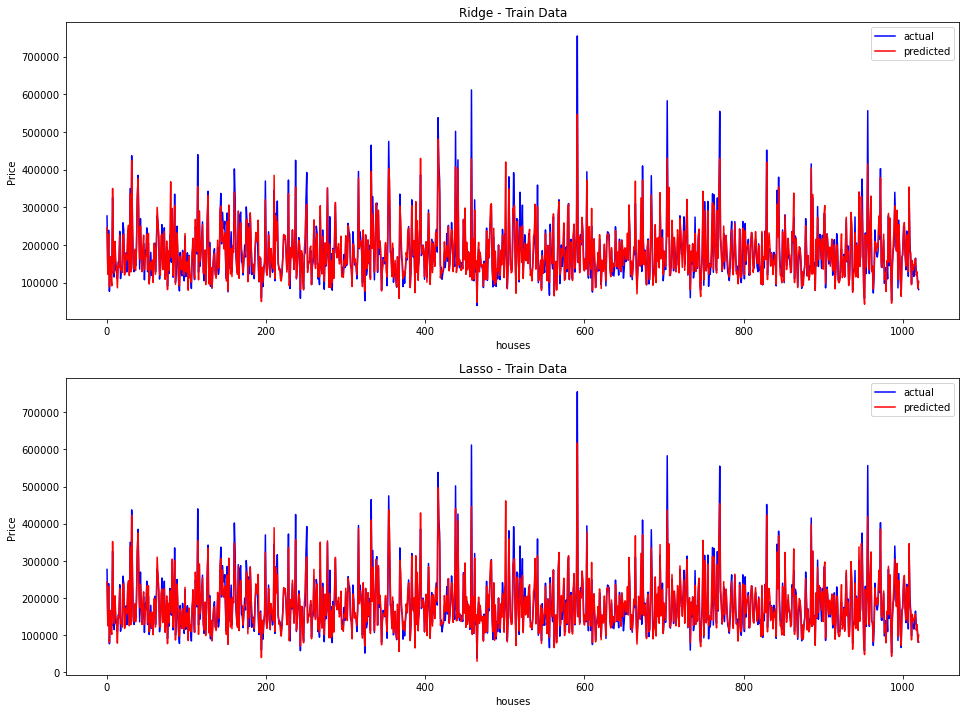

In [242]:
x_len = len (X.index)
Xs = [i for i in range(x_len)]

plt.figure (figsize=(16,12))

#RIDGE
y_pred = ridge_model.predict (X)

plt.subplot (2, 1, 1)
plt.plot (Xs, y, color='blue')
plt.plot (Xs, y_pred, color='red')

plt.title  ('Ridge - Train Data')
plt.xlabel ('houses')
plt.ylabel ('Price')
plt.legend (['actual', 'predicted'], loc='upper right')

#LASSO
y_pred = lasso_model.predict (X)

plt.subplot (2, 1, 2)
plt.plot (Xs, y, color='blue')
plt.plot (Xs, y_pred, color='red')

plt.title  ('Lasso - Train Data')
plt.xlabel ('houses')
plt.ylabel ('Price')
plt.legend (['actual', 'predicted'], loc='upper right')

plt.show()

#### <font color=blue> Step 6.3: </font> Test Data - Line Plots

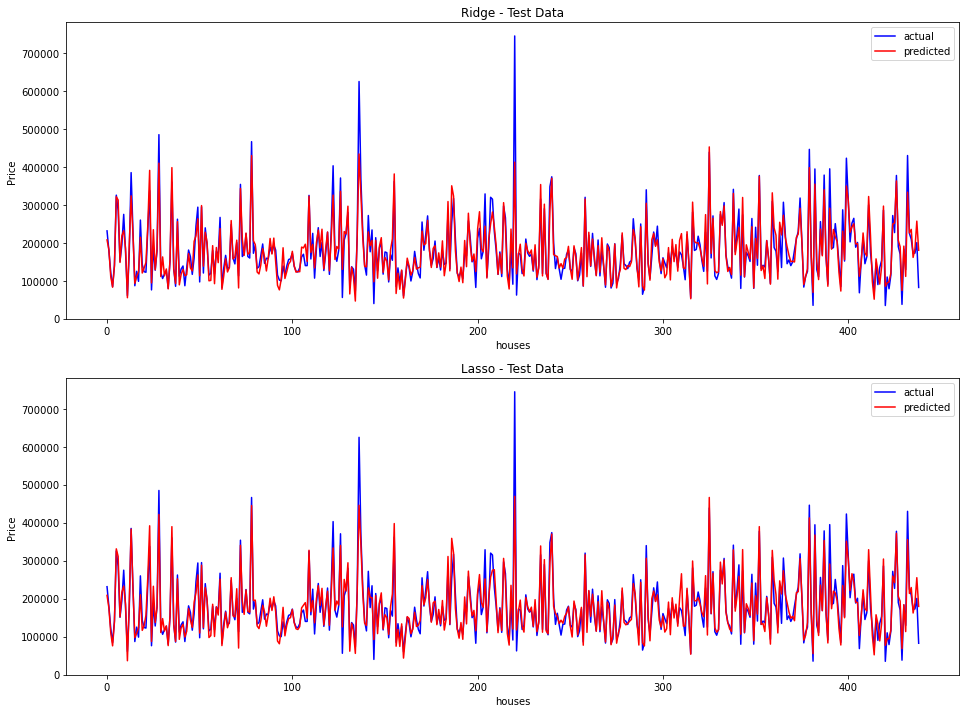

In [243]:
x_len = len (X_test.index)
Xs = [i for i in range(x_len)]

plt.figure (figsize=(16,12))

#RIDGE
y_pred_test = ridge_model.predict (X_test)

plt.subplot (2, 1, 1)
plt.plot (Xs, y_test, color='blue')
plt.plot (Xs, y_pred_test, color='red')

plt.title  ('Ridge - Test Data')
plt.xlabel ('houses')
plt.ylabel ('Price')
plt.legend (['actual', 'predicted'], loc='upper right')

#LASSO
y_pred_test = lasso_model.predict (X_test)

plt.subplot (2, 1, 2)
plt.plot (Xs, y_test, color='blue')
plt.plot (Xs, y_pred_test, color='red')

plt.title  ('Lasso - Test Data')
plt.xlabel ('houses')
plt.ylabel ('Price')
plt.legend (['actual', 'predicted'], loc='upper right')

plt.show()

#### <font color=blue> Step 6.4: </font> Residual Analysis

In [244]:
legends = [k for k in residuals]

In [245]:
legends

['Poly-Train',
 'Poly-Test',
 'PolySK-Train',
 'PolySK-Test',
 'Ridge-Train',
 'Ridge-Test',
 'Ridge2-Train',
 'Ridge2-Test',
 'Lasso-Train',
 'Lasso-Test',
 'Lasso2-Train',
 'Lasso2-Test']

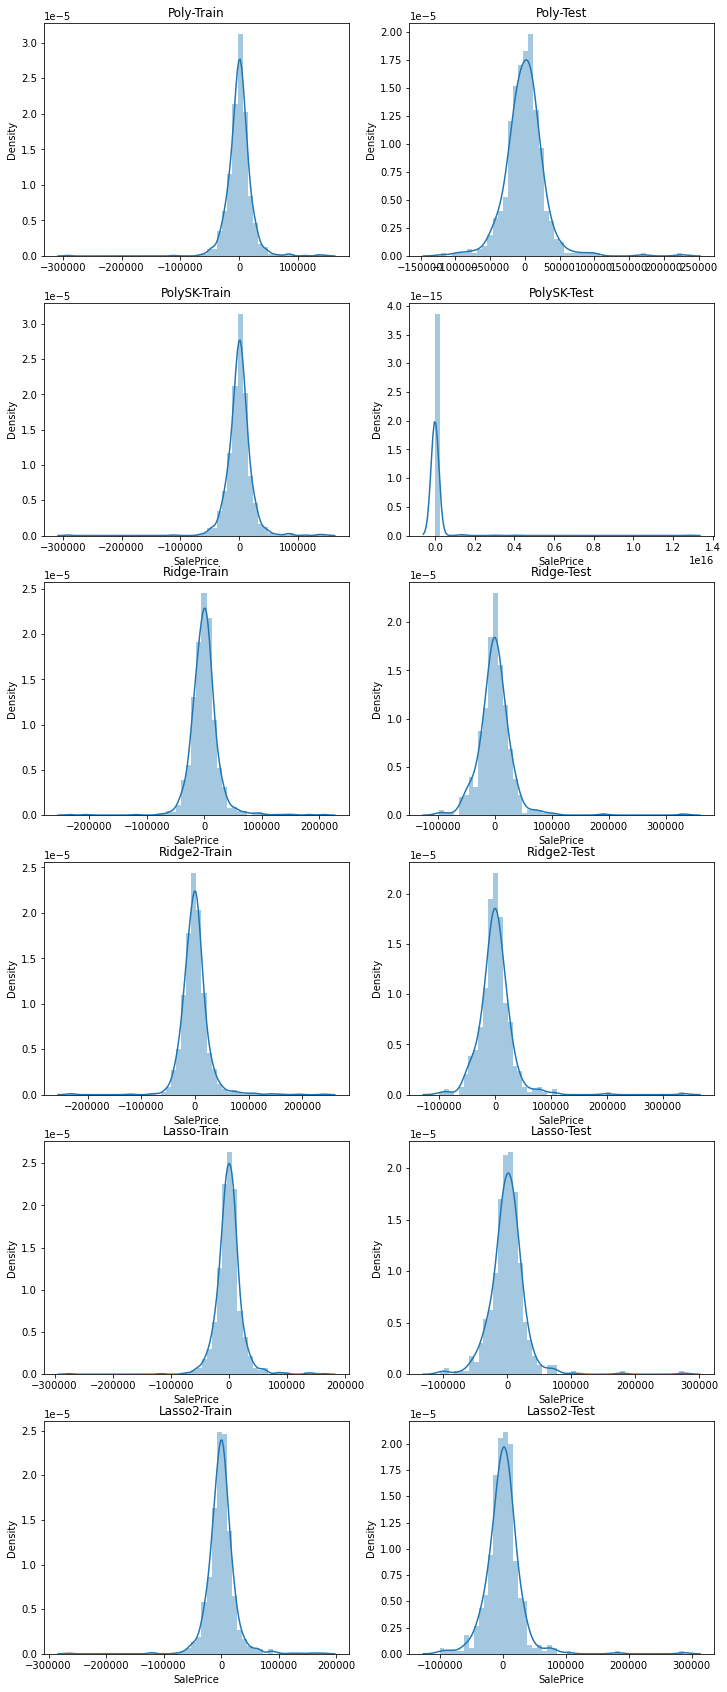

In [246]:
plt.figure (figsize=(12,30))

i=1
for k in residuals:
    plt.subplot  (6, 2, i)
    plt.title    (legends[i-1])
    sns.distplot (residuals[k])
    i +=1

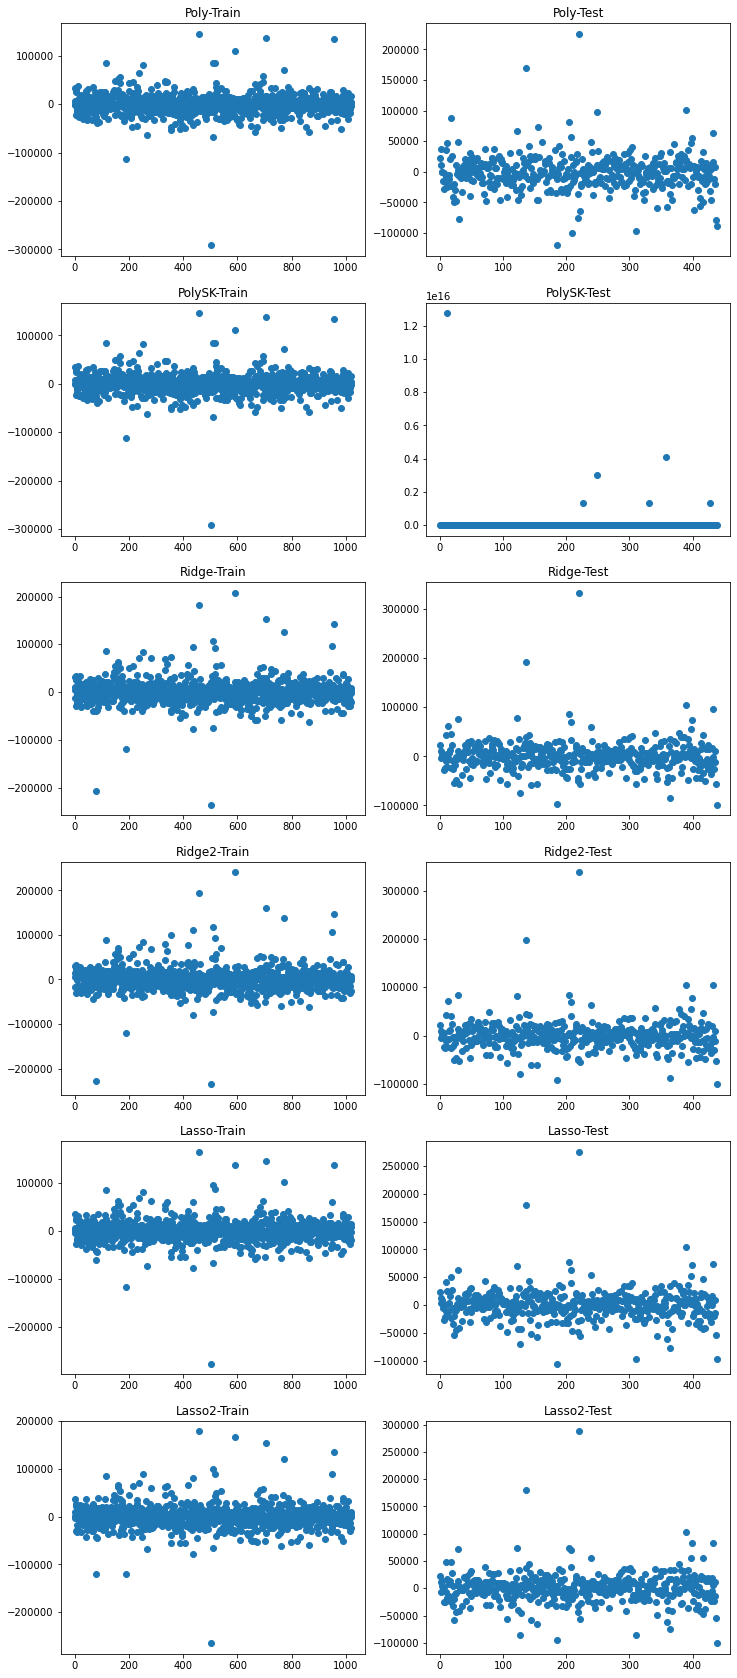

In [247]:
plt.figure (figsize=(12,30))

i=1
for k in residuals:
    res_k = residuals[k]
    
    x_len = len (res_k)
    Xs    = [i for i in range(x_len)]

    plt.subplot (6, 2, i)
    plt.scatter (Xs, res_k)
    plt.title   (legends[i-1])
    i +=1

#### <font color=blue> Step 7: </font> Questions and Answers

#### <font color=brown> Q1: Top Predictor Variables - Top 10 Features

##### <font color=green> 1. all_X_all_houses: </font> All Features are used AND all house data is used

In [248]:
coef_df.sort_values(by='Ridge', ascending=False).head(10).index

Index(['OverallQual', 'WdShngl_RoofMatl', 'StoneBr_Nbrhood', 'TotRmsAbvGrd',
       'GrLivArea', 'GarageCars', '2ndFlrSF', 'FullBath', 'NoRidge_Nbrhood',
       '1stFlrSF'],
      dtype='object')

In [249]:
coef_df.sort_values(by='Ridge2', ascending=False).head(10).index

Index(['OverallQual', 'StoneBr_Nbrhood', 'TotRmsAbvGrd', 'GarageCars',
       'WdShngl_RoofMatl', 'GrLivArea', 'FullBath', '2ndFlrSF',
       'NoRidge_Nbrhood', 'NridgHt_Nbrhood'],
      dtype='object')

In [250]:
coef_df.sort_values(by='Lasso', ascending=False).head(10).index

Index(['GrLivArea', 'WdShngl_RoofMatl', 'OverallQual', 'StoneBr_Nbrhood',
       'LotArea', 'BsmtFinSF1', 'OverallCond', 'GarageCars', 'NoRidge_Nbrhood',
       'TotRmsAbvGrd'],
      dtype='object')

In [251]:
coef_df.sort_values(by='Lasso2', ascending=False).head(10).index

Index(['GrLivArea', 'WdShngl_RoofMatl', 'OverallQual', 'StoneBr_Nbrhood',
       'GarageCars', 'NoRidge_Nbrhood', 'NridgHt_Nbrhood', 'LotArea',
       'OverallCond', 'TotRmsAbvGrd'],
      dtype='object')

In [252]:
def re_analyze_data (h_data, cols, r_alpha, l_alpha):
    h_train, h_test = tts (h_data, train_size=0.70, random_state=1)
    
    mms = MinMaxScaler()
    h_train [cols] = mms.fit_transform (h_train[cols])
    y_      = h_train.pop ('SalePrice')
    X_      = h_train[cols]
    
    coef_df_ = pd.DataFrame (index=cols, columns=['Ridge', 'Lasso'])

    r_model_  = Ridge (alpha = r_alpha)
    r_model_.fit (X_, y_)
    coef_df_ ['Ridge']  = r_model_.coef_
    
    l_model_  = Lasso (alpha = l_alpha)
    l_model_.fit (X_, y_)
    coef_df_ ['Lasso']  = l_model_.coef_
    
    return coef_df_

##### <font color=green> 2. all_X_reduced_houses: </font> All Features are used BUT outliers are removed from house data

In [253]:
coef_df_ = re_analyze_data (houses [ houses['SalePrice'] < 350000 ], X_cols, ridge_alpha, lasso_alpha)

In [254]:
coef_df_.sort_values(by='Ridge', ascending=False).head(10).index

Index(['OverallQual', 'TotRmsAbvGrd', 'GarageCars', 'GrLivArea', '2ndFlrSF',
       'OverallCond', 'GarageArea', 'NoRidge_Nbrhood', '1stFlrSF',
       'NridgHt_Nbrhood'],
      dtype='object')

In [255]:
coef_df_.sort_values(by='Lasso', ascending=False).head(10).index

Index(['GrLivArea', 'OverallQual', 'OverallCond', 'GarageArea', 'TotalBsmtSF',
       'NoRidge_Nbrhood', 'TotRmsAbvGrd', 'NridgHt_Nbrhood', 'LotArea',
       'GarageCars'],
      dtype='object')

##### <font color=green> 3. reduced_X_all_houses: </font> Single Value Features are removed BUT all house data is used

In [256]:
coef_df_ = re_analyze_data (houses, reduced_X_cols, ridge_alpha, lasso_alpha)

In [257]:
coef_df_.sort_values(by='Ridge', ascending=False).head(10).index

Index(['OverallQual', 'StoneBr_Nbrhood', 'GarageCars', 'GrLivArea',
       'TotRmsAbvGrd', '2ndFlrSF', 'FullBath', 'NoRidge_Nbrhood', '1stFlrSF',
       'NridgHt_Nbrhood'],
      dtype='object')

In [258]:
coef_df_.sort_values(by='Lasso', ascending=False).head(10).index

Index(['GrLivArea', 'LotArea', 'OverallQual', 'StoneBr_Nbrhood', 'GarageCars',
       'NoRidge_Nbrhood', 'NridgHt_Nbrhood', 'TotRmsAbvGrd', 'OverallCond',
       'FullBath'],
      dtype='object')

##### <font color=green> 4. reduced_X_reduced_houses: </font> Single Value Features are removed AND outliers are also removed from house data

In [259]:
coef_df_ = re_analyze_data (houses [ houses['SalePrice'] < 350000 ], reduced_X_cols, ridge_alpha, lasso_alpha)

In [260]:
coef_df_.sort_values(by='Ridge', ascending=False).head(10).index

Index(['OverallQual', 'TotRmsAbvGrd', 'GarageCars', '2ndFlrSF', 'GrLivArea',
       'OverallCond', 'NoRidge_Nbrhood', 'GarageArea', 'NridgHt_Nbrhood',
       '1stFlrSF'],
      dtype='object')

In [261]:
coef_df_.sort_values(by='Lasso', ascending=False).head(10).index

Index(['GrLivArea', 'OverallQual', 'GarageCars', 'TotRmsAbvGrd', 'OverallCond',
       'NoRidge_Nbrhood', 'NridgHt_Nbrhood', 'Ex_BsmtQual', '2ndFlrSF',
       'Ext_BrkFace'],
      dtype='object')

#### <font color=brown> Q3: </font> Re-model without top 5 features

In [264]:
#Ridge - Remove top 5 features
top5Ridge   = coef_df.sort_values(by='Ridge', ascending=False).head(5).index

X_colsRidge = copy.deepcopy (X_cols)
for f in top5Ridge:
    X_colsRidge.remove (f)
    
X_r = X [X_colsRidge]

In [265]:
#Ridge - Remodel without the top 5 feautres
ridge_new_model = Ridge(alpha = ridge_alpha)
ridge_new_model.fit (X_r, y)

Ridge(alpha=5.3)

In [266]:
coef_df2 = pd.DataFrame (index=X_colsRidge, columns=['Without_Top5'])
coef_df2 ['Without_Top5'] = ridge_new_model.coef_
coef_df2.sort_values(by='Without_Top5', ascending=False).head(5).index

Index(['1stFlrSF', '2ndFlrSF', 'GarageCars', 'FullBath', 'NoRidge_Nbrhood'], dtype='object')

In [267]:
#Lasso - Remove top 5 features
top5Lasso = coef_df.sort_values(by='Lasso', ascending=False).head(5).index

X_colsLasso = copy.deepcopy (X_cols)
for f in top5Lasso:
    X_colsLasso.remove (f)
    
X_l = X [X_colsLasso]

In [268]:
#Lasso - Remodel without the top 5 feautres
lasso_new_model = Lasso(alpha = lasso_alpha)
lasso_new_model.fit (X_l, y)

Lasso(alpha=59.0)

In [269]:
coef_df2 = pd.DataFrame (index=X_colsLasso, columns=['Without_Top5'])
coef_df2 ['Without_Top5'] = lasso_new_model.coef_
coef_df2.sort_values(by='Without_Top5', ascending=False).head(5).index

Index(['1stFlrSF', '2ndFlrSF', 'TotalBsmtSF', 'BsmtFinSF1', 'GarageCars'], dtype='object')

#### <font color=blue> END OF NOTEBOOK </font>